In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import pickle
from torch.amp import GradScaler, autocast
import random
from multiprocessing import Pool, cpu_count
from tqdm import tqdm


In [3]:
# 1. Set Random Seed for Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # torch.backends.cudnn.deterministic = True  # Uncomment for deterministic behavior

set_seed()

In [4]:
# 2. Load Datasets
events = pd.read_csv('data/events.csv')
category_tree = pd.read_csv('data/category_tree.csv')
item_properties_part1 = pd.read_csv('data/item_properties_part1.csv')
item_properties_part2 = pd.read_csv('data/item_properties_part2.csv')

# 3. Inspect Data
print("Events DataFrame:")
print(events.head())
print(events.info())

print("\nItem Properties Part 1:")
print(item_properties_part1.head())
print(item_properties_part1.info())

print("\nItem Properties Part 2:")
print(item_properties_part2.head())
print(item_properties_part2.info())

print("\nCategory Tree:")
print(category_tree.head())
print(category_tree.info())

Events DataFrame:
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None

Item Properties Part 1:
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014    

In [5]:
# 4. Concatenate Item Properties
catalog_part1 = item_properties_part1.copy()
catalog_part2 = item_properties_part2.copy()

# Ensure consistent column names
print("Columns in Part 1:", catalog_part1.columns.tolist())
print("Columns in Part 2:", catalog_part2.columns.tolist())

# If column names differ, rename them to match (Adjust based on your actual column names)
# Example:
# catalog_part2.rename(columns={'prod_id': 'itemid', 'prod_title': 'title'}, inplace=True)

# Concatenate
catalog = pd.concat([catalog_part1, catalog_part2], ignore_index=True)
print("\nCombined Catalog:")
print(catalog.head())
print(catalog.info())


Columns in Part 1: ['timestamp', 'itemid', 'property', 'value']
Columns in Part 2: ['timestamp', 'itemid', 'property', 'value']

Combined Catalog:
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB
None


In [6]:
# Check for duplicate item_ids
duplicate_items = catalog[catalog.duplicated(subset=['itemid'], keep=False)]
print(f"\nNumber of duplicate items: {duplicate_items.shape[0]}")

# If duplicates exist, decide on a strategy to handle them (e.g., keep the first occurrence)
catalog.drop_duplicates(subset=['itemid'], keep='first', inplace=True)


Number of duplicate items: 20275902


In [7]:
# Merge with category_tree
print("Category Tree:")
print(category_tree.head())

# Assuming category_tree has 'categoryid', 'parentid', 'category_name'
if 'categoryid' in catalog.columns and 'categoryid' in category_tree.columns:
    catalog = catalog.merge(category_tree[['categoryid', 'parentid']], on='categoryid', how='left')
    print("\nCatalog after merging with Category Tree:")
    print(catalog.head())
else:
    print("Cannot merge catalog with category_tree.csv. Check the column names for Category IDs.")

Category Tree:
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0
Cannot merge catalog with category_tree.csv. Check the column names for Category IDs.


In [8]:
# Convert timestamp to datetime in events
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')


In [9]:
# Filter relevant events (e.g., purchases and views)
relevant_events = events[events['event'].isin(['view', 'purchase'])].copy()


In [10]:
# Handle missing values in catalog
# Fill missing descriptions or other textual fields with empty strings
if 'ProductDescription' in catalog.columns:
    catalog['ProductDescription'] = catalog['ProductDescription'].fillna('')
else:
    # If 'ProductDescription' is not present, create it or handle accordingly
    catalog['ProductDescription'] = ''

In [11]:
# Encode user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

In [12]:
# Encode 'visitorid' as 'user'
relevant_events['user'] = user_encoder.fit_transform(relevant_events['visitorid'].astype(str))


In [13]:
# Encode 'itemid' as 'item'
relevant_events['item'] = item_encoder.fit_transform(relevant_events['itemid'].astype(str))


In [14]:
# Select relevant columns for interactions
data = relevant_events[['user', 'item', 'event']].copy()

# Map event types to interaction values
interaction_mapping = {'view': 1, 'purchase': 2}
data['interaction'] = data['event'].map(interaction_mapping)

# Drop the original 'event' column
data.drop('event', axis=1, inplace=True)

print("\nProcessed Interaction Data:")
print(data.head())


Processed Interaction Data:
      user    item  interaction
0   581286  143079            1
1  1395678   82986            1
2   122133  122312            1
3   831931   85528            1
4  1350167  149548            1


In [15]:
# 5. Exploratory Data Analysis (EDA)
num_users = data['user'].nunique()
num_items = data['item'].nunique()
print(f'\nNumber of users: {num_users}')
print(f'Number of items: {num_items}')


Number of users: 1404179
Number of items: 234838


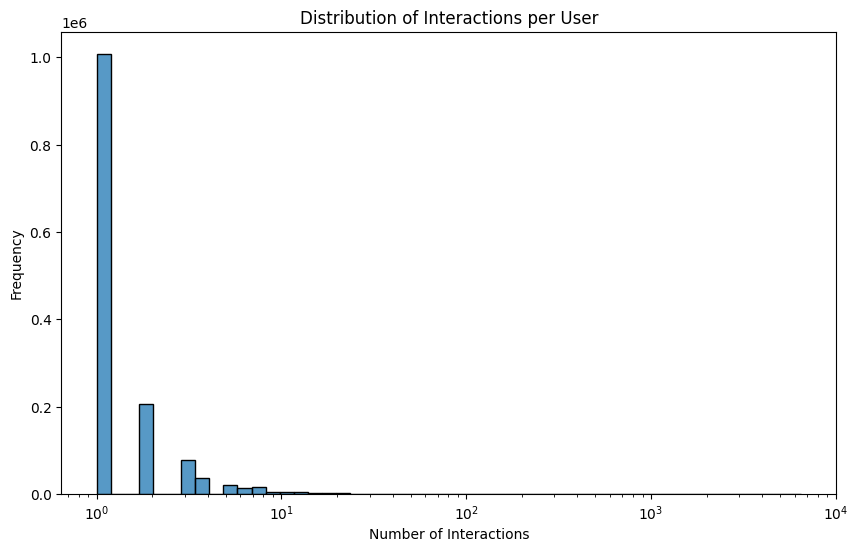

In [16]:
# Distribution of interactions per user
plt.figure(figsize=(10,6))
sns.histplot(data['user'].value_counts(), bins=50, log_scale=True)
plt.title('Distribution of Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()

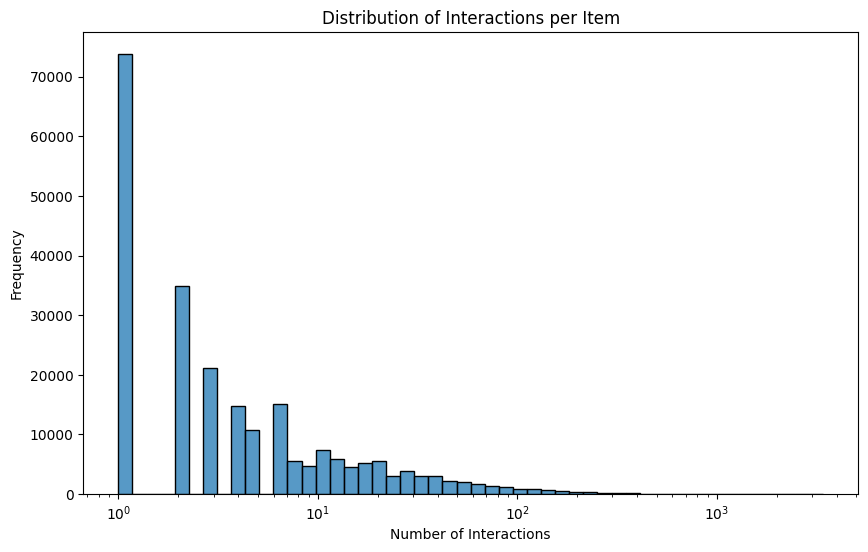

In [17]:
# Distribution of interactions per item
plt.figure(figsize=(10,6))
sns.histplot(data['item'].value_counts(), bins=50, log_scale=True)
plt.title('Distribution of Interactions per Item')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.show()

In [21]:
# 9. Split Data into Training and Testing Sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"\nTraining data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# 10. Generate Negative Samples (Optimized Vectorized Approach)
def generate_negative_samples_vectorized(df, num_negatives=4):
    """
    Generate negative samples for each user using vectorized operations.

    Args:
        df (pd.DataFrame): DataFrame containing user-item interactions.
        num_negatives (int): Number of negative samples per user.

    Returns:
        pd.DataFrame: DataFrame containing negative samples with columns ['user', 'item', 'label'].
    """
    users = df['user'].unique()
    all_items = df['item'].unique()
    all_items_set = set(all_items)
    
    # Create a mapping from user to set of positive items
    user_to_pos_items = df.groupby('user')['item'].apply(set).to_dict()
    
    negative_users = []
    negative_items = []
    negative_labels = []
    
    for user in tqdm(users, desc="Generating Negative Samples"):
        pos_items = user_to_pos_items[user]
        neg_candidates = list(all_items_set - pos_items)
        
        if len(neg_candidates) >= num_negatives:
            sampled_negatives = np.random.choice(neg_candidates, size=num_negatives, replace=False)
        else:
            # If not enough candidates, sample with replacement
            sampled_negatives = np.random.choice(neg_candidates, size=num_negatives, replace=True)
        
        negative_users.extend([user] * num_negatives)
        negative_items.extend(sampled_negatives)
        negative_labels.extend([0] * num_negatives)
    
    negative_df = pd.DataFrame({
        'user': negative_users,
        'item': negative_items,
        'label': negative_labels
    })
    
    return negative_df


Training data shape: (2131449, 3)
Testing data shape: (532863, 3)


In [22]:
# 11. Prepare Training and Testing Datasets with Negative Samples
# Positive samples
train_positive = train_data[['user', 'item']].copy()
train_positive['label'] = 1

# Negative samples (optimized vectorized approach)
print("Generating negative samples for training...")
train_negative = generate_negative_samples_vectorized(train_data, num_negatives=4)

# Combine positive and negative samples
train_combined = pd.concat([train_positive, train_negative], ignore_index=True)

# Shuffle the combined training data
train_combined = train_combined.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Total training samples: {train_combined.shape[0]}")

# Similarly, prepare testing data
# Positive samples
test_positive = test_data[['user', 'item']].copy()
test_positive['label'] = 1

print("Generating negative samples for testing...")
test_negative = generate_negative_samples_vectorized(test_data, num_negatives=4)

# Combine positive and negative samples for test data
test_combined = pd.concat([test_positive, test_negative], ignore_index=True)

# Shuffle the combined test data
test_combined = test_combined.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Total testing samples: {test_combined.shape[0]}")

Generating negative samples for training...


Generating Negative Samples: 100%|██████████| 1193499/1193499 [26:29:26<00:00, 12.51it/s]        


Total training samples: 6905445
Generating negative samples for testing...


Generating Negative Samples: 100%|██████████| 396718/396718 [13:13:48<00:00,  8.33it/s]       


Total testing samples: 2119735


In [23]:
# 12. Define PyTorch Dataset and DataLoader
class InteractionDataset(Dataset):
    def __init__(self, df):
        self.user = torch.tensor(df['user'].values, dtype=torch.long)
        self.item = torch.tensor(df['item'].values, dtype=torch.long)
        self.label = torch.tensor(df['label'].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.user)
    
    def __getitem__(self, idx):
        return self.user[idx], self.item[idx], self.label[idx]

# Instantiate the Datasets
train_dataset = InteractionDataset(train_combined)
test_dataset = InteractionDataset(test_combined)

# Create DataLoaders with optimized settings
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)


In [24]:
# 13. Define the Neural Collaborative Filtering (NCF) Model
class NCFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=50):
        super(NCFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.output_layer = nn.Linear(64, 1)
    
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output_layer(x)  # No sigmoid here
        return x.squeeze()

In [25]:
# 14. Instantiate the Model, Define Loss and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nUsing device: {device}')

model = NCFModel(num_users, num_items, embedding_size=50).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()



Using device: cuda


In [31]:
# 15. Training Loop with Early Stopping
from sklearn.metrics import accuracy_score, roc_auc_score

num_epochs = 10
best_val_loss = float('inf')
patience = 3
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for batch in tqdm(train_loader, desc="Training"):
        user, item, label = batch
        user = user.to(device, non_blocking=True)
        item = item.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):
            outputs = model(user, item)
            loss = criterion(outputs, label)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item() * user.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        epoch_acc += (preds == label).sum().item()
        total += user.size(0)
    
    epoch_loss /= total
    epoch_acc /= total
    
    # Validation Phase
    model.eval()
    val_loss = 0
    val_acc = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            user, item, label = batch
            user = user.to(device, non_blocking=True)
            item = item.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)
            
            with autocast(device_type='cuda'):
                outputs = model(user, item)
                loss = criterion(outputs, label)
            
            val_loss += loss.item() * user.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            val_acc += (preds == label).sum().item()
            val_total += user.size(0)
    
    val_loss /= val_total
    val_acc /= val_total
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Early Stopping and Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_ncf_model.pth')
        print("Model saved!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break



Epoch 1/10


Validation: 100%|██████████| 2071/2071 [01:11<00:00, 28.91it/s]



Epoch [1/10] Summary:
Training Loss: 0.3053, Training Accuracy: 0.8707
Validation Loss: 0.5339, Validation Accuracy: 0.7563
Model saved!

Epoch 2/10


Validation: 100%|██████████| 2071/2071 [01:21<00:00, 25.42it/s]



Epoch [2/10] Summary:
Training Loss: 0.2880, Training Accuracy: 0.8799
Validation Loss: 0.5527, Validation Accuracy: 0.7502

Epoch 3/10


Validation: 100%|██████████| 2071/2071 [01:19<00:00, 26.19it/s]



Epoch [3/10] Summary:
Training Loss: 0.2708, Training Accuracy: 0.8887
Validation Loss: 0.5766, Validation Accuracy: 0.7431

Epoch 4/10


Validation: 100%|██████████| 2071/2071 [01:17<00:00, 26.59it/s]


Epoch [4/10] Summary:
Training Loss: 0.2544, Training Accuracy: 0.8966
Validation Loss: 0.6010, Validation Accuracy: 0.7386
Early stopping triggered!


In [32]:
# 16. Evaluating the Model
# Load the best model
model.load_state_dict(torch.load('best_ncf_model.pth'))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        user, item, label = batch
        user = user.to(device, non_blocking=True)
        item = item.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)
        
        outputs = model(user, item)
        preds = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid here
        labels = label.cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels)

# Compute metrics
pred_binary = [1 if p >= 0.5 else 0 for p in all_preds]
accuracy = accuracy_score(all_labels, pred_binary)
roc_auc = roc_auc_score(all_labels, all_preds)

print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")

C:\Users\viraj\AppData\Local\Temp\ipykernel_37632\1017832022.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_ncf_model.pth'))
Eval


Test Accuracy: 0.7563
Test ROC-AUC: 0.7572


In [33]:
# 17. Saving the Model and Encoders
# Save the trained model
torch.save(model.state_dict(), 'ncf_model.pth')

# Save encoders
with open('user_encoder.pkl', 'wb') as f:
    pickle.dump(user_encoder, f)

with open('item_encoder.pkl', 'wb') as f:
    pickle.dump(item_encoder, f)

# Save user_positive_items for recommendations
user_positive_items = defaultdict(set)
for row in train_data.itertuples(index=False):
    user_positive_items[row.user].add(row.item)

with open('user_positive_items.pkl', 'wb') as f:
    pickle.dump(user_positive_items, f)

print("\nModel and encoders have been saved successfully.")


Model and encoders have been saved successfully.


In [44]:
# Prepare validation dataset (using positive interactions only)
def create_validation_dataset(df):
    user = tf.constant(df['user'].values, dtype=tf.int32)
    item = tf.constant(df['item'].values, dtype=tf.int32)
    label = tf.constant(np.ones(len(df)), dtype=tf.float32)  # All positive labels
    return tf.data.Dataset.from_tensor_slices(((user, item), label)).batch(1024)

validation_dataset = create_validation_dataset(test_data)


In [17]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())



PyTorch Version: 2.4.1
CUDA Available: True
